# A/B Results – Narrative Summary

This notebook ingests the CSVs generated by the CLI (`ab-uplift-run` or `scripts/run_all.py`) and presents a concise narrative:
1) **Checks**: SRM/Balance, Propensity overlap, Effective Sample Size (ESS)
2) **Effects**: Absolute diff + CIs, Odds Ratios, CUPAC; Causal ATEs with CIs
3) **Targeting**: Qini curve, AUUC, and Top-K policy table
4) **Appendix**: Optional ROI scenario analysis


In [9]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image

# --- Find the project root (first parent that has reports/tables) ---
def find_base():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        if (p / "reports" / "tables").exists():
            return p
    return here  # fallback if not found

# Optional override via env var (set ABU_ROOT to your repo path)
BASE_OVERRIDE = (os.getenv("ABU_ROOT") or "").strip() or None

base = Path(BASE_OVERRIDE) if BASE_OVERRIDE else find_base()
tables = base / "reports" / "tables"
figs   = base / "reports" / "figures"
print("Base dir:", base)

# --- CSV loader ---
def load_csv(name: str):
    p = tables / name
    if p.exists():
        try:
            return pd.read_csv(p)
        except Exception as e:
            print(f"Could not read {p}: {e}")
            return None
    else:
        # uncomment next line if you want to see every missing file path
        # print(f"Missing: {p}")
        return None

# Load all artifacts
power   = load_csv("power_summary.csv")
primary = load_csv("primary_effect_summary.csv")
smd     = load_csv("smd_table.csv")
cupac   = load_csv("cupac_summary_gbm.csv")
ipw     = load_csv("ipw_aipw_summary.csv")
gains   = load_csv("uplift_qini_gains.csv")
topk    = load_csv("uplift_topk_policy.csv")

# Qini meta (headerless k/v CSV)
qini_total = None
auuc = None
meta_path = tables / "uplift_qini_meta.csv"
if meta_path.exists():
    try:
        m = pd.read_csv(meta_path, header=None)
        kv = dict(zip(m[0], m[1]))
        qini_total = float(kv.get("qini_total", np.nan))
        auuc = float(kv.get("auuc", np.nan))
    except Exception as e:
        print("Could not parse uplift_qini_meta.csv:", e)

display(Markdown("### Files loaded"))
for name, df in [
    ("power", power), ("primary", primary), ("smd", smd), ("cupac", cupac),
    ("ipw", ipw), ("gains", gains), ("topk", topk)
]:
    print(f"{name}: {'OK' if df is not None else 'missing'}")


Base dir: C:\Users\17176\Desktop\ab_uplift_repo


### Files loaded

power: OK
primary: OK
smd: OK
cupac: OK
ipw: OK
gains: OK
topk: OK


## 1) Checks: SRM/Balance & Overlap

**SMD balance:** |SMD|>0.10: 0, >0.25: 0. Top 5 imbalanced:

,covariate,mean_treat,mean_ctrl,smd,abs_smd
5,f3,4.171727,4.234868,-0.048756,0.048756
8,f6,-4.182903,-4.011615,-0.037855,0.037855
7,f5,4.026276,4.040862,-0.034964,0.034964
9,f7,5.106249,5.072266,0.028816,0.028816
1,f1,10.070357,10.067819,0.025204,0.025204


**Overlap:** ESS/N ≈ **0.51**, % |ps| outside [0.05,0.95]: **0.00%**

**Propensity overlap histogram**

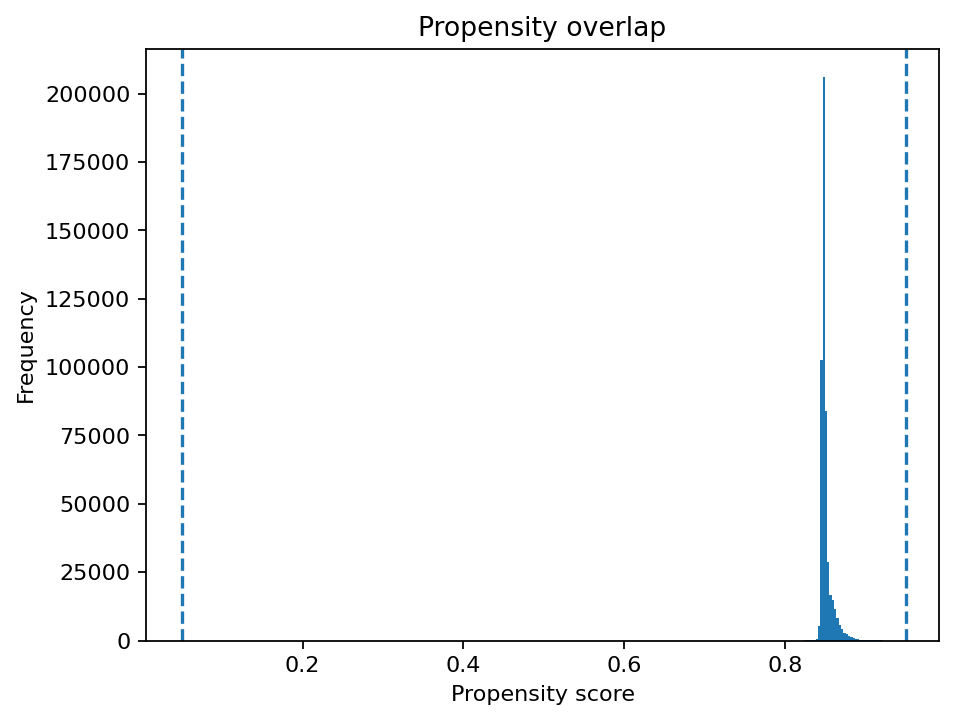

In [4]:
if smd is not None and len(smd):
    smd2 = smd.copy(); smd2['abs_smd'] = smd2['smd'].abs()
    over_10 = int((smd2['abs_smd']>0.10).sum()); over_25 = int((smd2['abs_smd']>0.25).sum())
    display(Markdown(f"**SMD balance:** |SMD|>0.10: {over_10}, >0.25: {over_25}. Top 5 imbalanced:"))
    display(smd2.sort_values('abs_smd', ascending=False).head(5))
else:
    display(Markdown('_SMD table missing._'))

if ipw is not None and len(ipw):
    row = ipw.iloc[0]
    ess_frac = row.get('ess_frac', np.nan)
    pct_out = row.get('ps_pct_out_005_095', np.nan)
    display(Markdown(f"**Overlap:** ESS/N ≈ **{ess_frac:.2f}**, % |ps| outside [0.05,0.95]: **{pct_out:.2f}%**"))
else:
    display(Markdown('_IPW/AIPW summary missing._'))

prop_img = figs / 'propensity_hist.png'
if prop_img.exists():
    display(Markdown('**Propensity overlap histogram**'))
    display(Image(filename=str(prop_img)))
else:
    display(Markdown('_No propensity histogram found._'))

## 2) Effects: Primary + CUPAC + Causal ATEs

In [5]:
def bps(x): 
    return f"{x*1e4:.2f}"  # basis points

def pct(x): 
    return f"{x*100:.4f}%"

lines = []

# Primary effect + relative lift
if primary is not None and len(primary):
    p = primary.iloc[0]
    p_ctrl = float(p.get("p_control", float("nan")))
    p_trt  = float(p.get("p_treat", float("nan")))
    rel = (p_trt - p_ctrl)/p_ctrl if p_ctrl > 0 else float("nan")
    lines += [
        f"**Primary (unadjusted):** diff = **{bps(p['diff'])} bps** "
        f"(95% CI **[{bps(p['diff_ci_low'])}, {bps(p['diff_ci_high'])}]**), "
        f"OR = **{p['odds_ratio']:.3f}** (CI **{p['or_ci_low']:.3f}–{p['or_ci_high']:.3f}**).",
        f"Base rates: control **{pct(p_ctrl)}**, treatment **{pct(p_trt)}** → **{rel*100:.2f}% relative lift**."
    ]
else:
    lines += ["_Primary summary missing._"]

# CUPAC (variance reduction)
if cupac is not None and len(cupac):
    c = cupac.iloc[0]
    lines += [
        f"**CUPAC (adjusted):** OR = **{c['odds_ratio_adj']:.3f}** "
        f"(CI **{c['or_adj_ci_low']:.3f}–{c['or_adj_ci_high']:.3f}**), "
        f"baseline R² = **{c['r2_mu_hat']:.3f}**."
    ]
else:
    lines += ["_CUPAC summary missing._"]

# AIPW / IPW + quick health flags
if ipw is not None and len(ipw):
    i = ipw.iloc[0]
    ess = float(i.get("ess_frac", float("nan")))
    tail = float(i.get("ps_pct_out_005_095", float("nan")))
    ess_flag = "🟢" if ess >= 0.50 else ("🟡" if ess >= 0.40 else "🔴")
    tail_flag = "🟢" if tail <= 1.0 else ("🟡" if tail <= 5.0 else "🔴")
    lines += [
        f"**AIPW ATE:** **{pct(i['ate_aipw'])}** (95% CI **[{pct(i['ate_aipw_ci_low'])}, {pct(i['ate_aipw_ci_high'])}]**)"
        f" | **IPW ATE:** {pct(i['ate_ipw'])} (CI [{pct(i['ate_ipw_ci_low'])}, {pct(i['ate_ipw_ci_high'])}]).",
        f"Overlap/weights: ESS/N **{ess:.2f}** {ess_flag}, %|ps|∉[0.05,0.95] **{tail:.2f}%** {tail_flag}."
    ]
else:
    lines += ["_IPW/AIPW summary missing._"]

# Consistency checks (optional sanity)
if primary is not None and len(primary):
    p = primary.iloc[0]
    ok_dir = (p['diff'] > 0) == (p['odds_ratio'] > 1)
    lines += [f"_Consistency:_ direction match between diff and OR → **{ok_dir}**."]

# Business takeaway from Top-K + Qini
if topk is not None and len(topk):
    # pull the 10% and 20% rows if present
    try:
        k10 = float(topk.loc[(topk["top_prop"] - 0.10).abs() < 1e-6, "qini"].iloc[0])
    except Exception:
        k10 = float("nan")
    try:
        k20 = float(topk.loc[(topk["top_prop"] - 0.20).abs() < 1e-6, "qini"].iloc[0])
    except Exception:
        k20 = float("nan")
    msg = "Target top 10–20% by uplift"
    if np.isfinite(k10) and np.isfinite(k20):
        msg += f" → incremental conversions ≈ **{k10:.1f}–{k20:.1f}**."
    lines += [f"**Targeting recommendation:** {msg}"]
elif gains is not None and len(gains):
    # fallback: interpolate from gains curve
    from numpy import interp
    q = gains["qini"].to_numpy()
    x = gains["top_prop"].to_numpy()
    k10 = float(interp(0.10, x, q))
    k20 = float(interp(0.20, x, q))
    lines += [f"**Targeting recommendation:** Target top 10–20% by uplift → incremental conversions ≈ **{k10:.1f}–{k20:.1f}**."]
else:
    lines += ["_Top-K policy/gains missing for recommendation._"]

display(Markdown(" \n".join(lines)))

**Primary (unadjusted):** diff = **9.78 bps** (95% CI **[6.11, 13.45]**), OR = **1.470** (CI **1.245–1.736**). 
Base rates: control **0.2088%**, treatment **0.3066%** → **46.85% relative lift**. 
**CUPAC (adjusted):** OR = **1.645** (CI **1.336–2.025**), baseline R² = **0.167**. 
**AIPW ATE:** **0.0806%** (95% CI **[0.0433%, 0.1178%]**) | **IPW ATE:** 0.0790% (CI [0.0398%, 0.1182%]). 
Overlap/weights: ESS/N **0.51** 🟢, %|ps|∉[0.05,0.95] **0.00%** 🟢. 
_Consistency:_ direction match between diff and OR → **True**. 
**Targeting recommendation:** Target top 10–20% by uplift → incremental conversions ≈ **33.5–43.9**.

## 3) Targeting: Qini / AUUC and Top-K policy

**Uplift Qini gains (head):**

,top_%,qini,n_obs
0,10,33.535,50000
1,20,43.906,100000
2,30,48.049,150000
3,40,52.773,200000
4,50,54.900,250000


**Qini total (@100%)** ≈ **62.165**, **AUUC** ≈ **47.963**

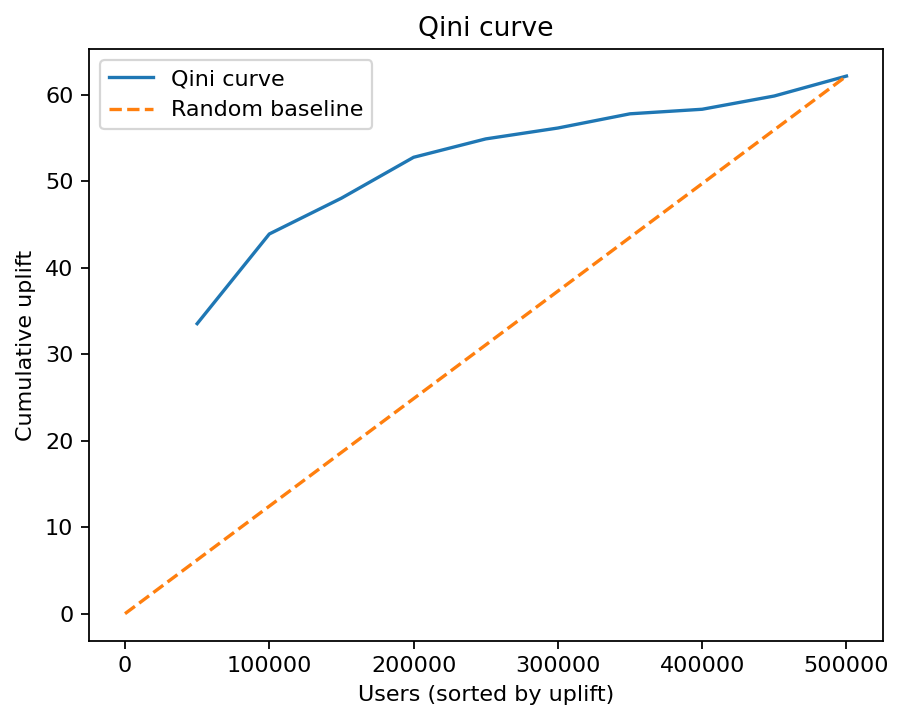

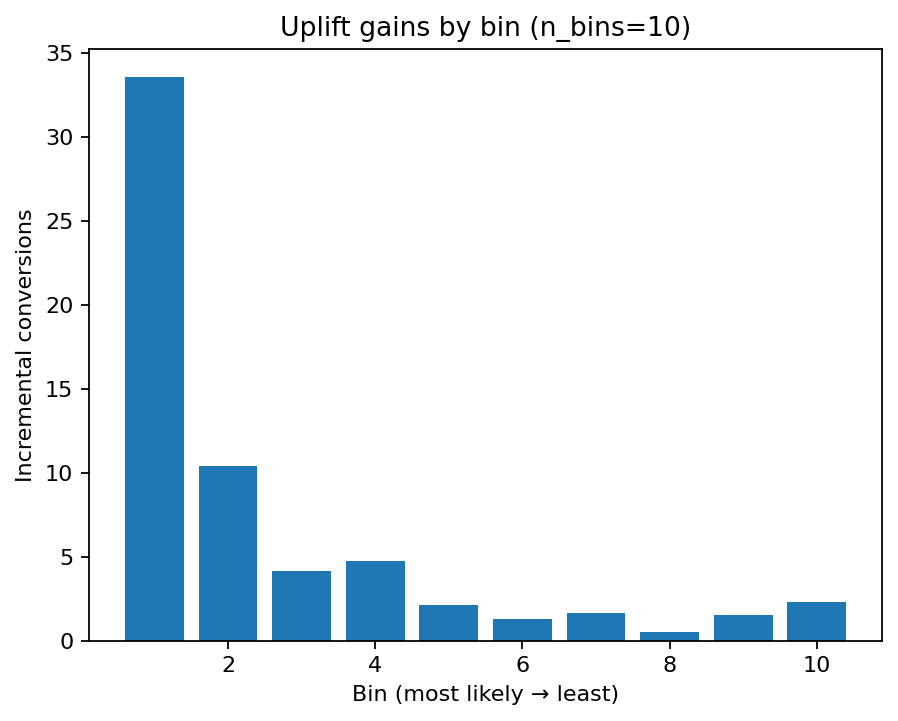

**Top-K policy (Qini at selected target proportions):**

,Target %,Users targeted,Qini,Share of total Qini (%)
0,10,50000,33.535,53.9
1,20,100000,43.906,70.6
2,30,150000,48.049,77.3
3,40,200000,52.773,84.9
4,50,250000,54.900,88.3


**Takeaway:** target the **top 10–20%** by uplift → captures ≈ **53.9%–70.6%** of total incremental conversions (~50,000–100,000 users).

_Sanity_: Qini monotone non-decreasing → **True**; incremental gains non-negative → **True**.

In [6]:
# ==============================
# 3) Targeting: Qini / AUUC and Top-K policy (FAANG-quality)
# ==============================
from IPython.display import display, Markdown, Image
import numpy as np
import pandas as pd

def _round_series(s, k=3):
    try:
        return s.round(k)
    except Exception:
        return s

# ---------- 1) Show gains head ----------
if gains is not None and len(gains):
    gdisp = gains.copy()
    # friendlier display: top_prop as integer percent if present
    if "top_prop" in gdisp:
        gdisp = gdisp.assign(top_prop=(gdisp["top_prop"] * 100).round(0).astype(int))
        gdisp = gdisp.rename(columns={"top_prop": "top_%"})
    if "qini" in gdisp:
        gdisp["qini"] = _round_series(gdisp["qini"], 3)
    display(Markdown("**Uplift Qini gains (head):**"))
    display(gdisp.head())
else:
    display(Markdown("_Qini gains file missing._"))

# ---------- 2) Qini total / AUUC (with safe fallbacks) ----------
# if meta not loaded, compute from gains
if (qini_total is None or (isinstance(qini_total, float) and np.isnan(qini_total))) and gains is not None and len(gains):
    qini_total = float(gains["qini"].iloc[-1])
if (auuc is None or (isinstance(auuc, float) and np.isnan(auuc))) and gains is not None and len(gains):
    auuc = float(np.trapz(gains["qini"].to_numpy(), gains["top_prop"].to_numpy()))
if qini_total is not None and np.isfinite(qini_total):
    display(Markdown(f"**Qini total (@100%)** ≈ **{qini_total:.3f}**, **AUUC** ≈ **{(auuc if auuc is not None else float('nan')):.3f}**"))

# ---------- 3) Figures (already generated by CLI) ----------
for fig_name in ("qini_curve.png", "uplift_gains_by_bin.png"):
    p = figs / fig_name
    if p.exists():
        display(Image(filename=str(p), width=720))
    else:
        display(Markdown(f"_{fig_name} not found in reports/figures._"))

# ---------- 4) Build Top-K policy (prefer CSV; fallback to interpolation) ----------
want_props = np.array([0.10, 0.20, 0.30, 0.40, 0.50])

def _policy_from_topk(df, props):
    out = []
    for p in props:
        m = df.loc[(df["top_prop"] - p).abs() < 1e-9, "qini"]
        out.append(float(m.iloc[0]) if len(m) else np.nan)
    return np.array(out)

def _policy_from_gains(df, props):
    x = df["top_prop"].to_numpy()
    y = df["qini"].to_numpy()
    return np.interp(props, x, y)

policy_qini = None
if topk is not None and len(topk) and {"top_prop","qini"}.issubset(topk.columns):
    policy_qini = _policy_from_topk(topk, want_props)
elif gains is not None and len(gains) and {"top_prop","qini"}.issubset(gains.columns):
    policy_qini = _policy_from_gains(gains, want_props)

# infer total users if available
N_total = None
if gains is not None and "n_obs" in gains.columns and len(gains):
    try:
        N_total = int(gains["n_obs"].max())
    except Exception:
        N_total = None

if policy_qini is not None and qini_total is not None and np.isfinite(qini_total):
    policy_df = pd.DataFrame({
        "top_prop": want_props,
        "Qini": np.round(policy_qini, 3),
        "Share of total Qini (%)": np.round(policy_qini / qini_total * 100, 1),
    })
    policy_df["Target %"] = (policy_df["top_prop"] * 100).round(0).astype(int)
    if N_total is not None:
        policy_df["Users targeted"] = (policy_df["top_prop"] * N_total).round(0).astype(int)
        cols = ["Target %", "Users targeted", "Qini", "Share of total Qini (%)"]
    else:
        cols = ["Target %", "Qini", "Share of total Qini (%)"]

    display(Markdown("**Top-K policy (Qini at selected target proportions):**"))
    display(policy_df[cols])

    # ---------- 5) Business takeaway + sanity checks ----------
    # concentration of lift
    try:
        q10 = float(policy_df.loc[policy_df["Target %"].eq(10), "Qini"].iloc[0])
        q20 = float(policy_df.loc[policy_df["Target %"].eq(20), "Qini"].iloc[0])
        share10 = q10 / qini_total * 100
        share20 = q20 / qini_total * 100
        msg_users = "" if N_total is None else f" (~{int(0.10*N_total):,}–{int(0.20*N_total):,} users)"
        display(Markdown(
            f"**Takeaway:** target the **top 10–20%** by uplift → captures ≈ "
            f"**{share10:.1f}%–{share20:.1f}%** of total incremental conversions{msg_users}."
        ))
    except Exception:
        pass

    # monotonicity / non-negative increments
    if gains is not None and len(gains) and {"top_prop","qini"}.issubset(gains.columns):
        q = gains["qini"].to_numpy()
        inc = np.diff(np.concatenate([[0], q]))
        monotone = bool(np.all(np.diff(q) >= -1e-9))
        nonneg = bool(np.all(inc >= -1e-9))
        display(Markdown(
            f"_Sanity_: Qini monotone non-decreasing → **{monotone}**; "
            f"incremental gains non-negative → **{nonneg}**."
        ))
else:
    display(Markdown("_Top-K policy could not be constructed (missing `top_prop`/`qini`)._"))

---
**Notes:**
- These results were generated with the project CLI. For reproducibility controls, adjust `--rows` and `--bins`.
- 85/15 allocation mirrors production holdouts; report ESS and AIPW CIs when using imbalanced splits.


## 4) Appendix: ROI scenaio analysis (optional)

In [7]:
# -----------------------------
# Appendix: ROI scenario analysis (assumptions)
# -----------------------------
from IPython.display import Markdown, display
import numpy as np
import pandas as pd

# ==== EDIT THESE TWO NUMBERS ====
VALUE_PER_CONVERSION = 100.0   # dollars of value per incremental conversion
CONTACT_COST_PER_USER = 0.05   # dollars to contact 1 targeted user
# ================================

GRID = np.arange(0.05, 0.55, 0.05)  # evaluate 5%,10%,...,50%

def _interp_qini(df, props):
    x = df["top_prop"].to_numpy()
    y = df["qini"].to_numpy()
    return np.interp(props, x, y)

if gains is None or not len(gains):
    display(Markdown("_ROI appendix skipped: `gains` table not loaded._"))
else:
    # infer total users from the gains table if available
    N_total = None
    if "n_obs" in gains.columns and len(gains):
        try:
            N_total = int(gains["n_obs"].max())
        except Exception:
            N_total = None

    if N_total is None:
        display(Markdown("_ROI appendix skipped: could not infer total population (`n_obs` missing). Add a manual override if needed._"))
    else:
        # Qini at each target % (incremental conversions)
        q_at = _interp_qini(gains, GRID)
        users = (GRID * N_total).astype(int)

        # Economics
        revenue = q_at * VALUE_PER_CONVERSION
        cost    = users * CONTACT_COST_PER_USER
        net     = revenue - cost
        roi     = np.divide(net, cost, out=np.full_like(net, np.nan), where=cost > 0)

        # Break-even diagnostics
        be_value_per_conv = np.divide(cost, q_at, out=np.full_like(cost, np.nan), where=q_at > 0)
        be_cost_per_user  = np.divide(VALUE_PER_CONVERSION * q_at, users, out=np.full_like(revenue, np.nan), where=users > 0)

        df = pd.DataFrame({
            "Target %": (GRID * 100).astype(int),
            "Users targeted": users,
            "Qini (incr conv)": np.round(q_at, 3),
            "Revenue ($)": np.round(revenue, 2),
            "Cost ($)": np.round(cost, 2),
            "Net ($)": np.round(net, 2),
            "ROI": np.round(roi, 3),
            "Break-even $/conv (given cost)": np.round(be_value_per_conv, 2),
            "Break-even $/user (given value)": np.round(be_cost_per_user, 4),
        })

        display(Markdown(
            f"**Assumptions:** value/conv = `${VALUE_PER_CONVERSION:.2f}`, "
            f"contact cost/user = `${CONTACT_COST_PER_USER:.4f}`, total users = **{N_total:,}**."
        ))
        display(Markdown("**ROI by target percent (scenario):**"))
        display(df)

        # Pick optimal target % by Net $
        best_idx = int(np.nanargmax(net))
        best = df.iloc[best_idx]
        display(Markdown(
            f"**Optimal by Net ($)** → target **{best['Target %']}%** "
            f"(users ≈ **{best['Users targeted']:,}**): Net ≈ **${best['Net ($)']:,}**, ROI ≈ **{best['ROI']}**."
        ))

        display(Markdown(
            "_Note: This appendix is a what-if scenario. Replace the inputs above with your business numbers, "
            "or omit this section when costs/values are unknown._"
        ))

**Assumptions:** value/conv = `$100.00`, contact cost/user = `$0.0500`, total users = **500,000**.

**ROI by target percent (scenario):**

,Target %,Users targeted,Qini (incr conv),Revenue ($),Cost ($),Net ($),ROI,Break-even $/conv (given cost),Break-even $/user (given value)
0,5,25000,33.535,3353.50,1250.0,2103.50,1.683,37.27,0.1341
1,10,50000,33.535,3353.50,2500.0,853.50,0.341,74.55,0.0671
2,15,75000,38.720,3872.05,3750.0,122.05,0.033,96.85,0.0516
3,20,100000,43.906,4390.59,5000.0,-609.41,-0.122,113.88,0.0439
4,25,125000,45.977,4597.74,6250.0,-1652.26,-0.264,135.94,0.0368
5,30,150000,48.049,4804.88,7500.0,-2695.12,-0.359,156.09,0.0320
6,35,175000,50.411,5041.11,8750.0,-3708.89,-0.424,173.57,0.0288
7,40,200000,52.773,5277.35,10000.0,-4722.65,-0.472,189.49,0.0264
8,45,225000,53.837,5383.66,11250.0,-5866.34,-0.521,208.97,0.0239
9,50,250000,54.900,5489.98,12500.0,-7010.02,-0.561,227.69,0.0220


**Optimal by Net ($)** → target **5.0%** (users ≈ **25,000.0**): Net ≈ **$2,103.5**, ROI ≈ **1.683**.

_Note: This appendix is a what-if scenario. Replace the inputs above with your business numbers, or omit this section when costs/values are unknown._